## Explaining Concepts with Knowledge Graphs (Llama 3.2 and Matplotlib)

This cookbook uses a local LLama3.2 pipeline implementation to generate knowledge graphs and then uses good old matplotlib to visualize it. We can use this for graph encoding and graph reasoning. 
All code is as is. 

In [33]:
#%pip install --upgrade transformers torch accelerate bitsandbytes matplotlib

In [8]:
import json

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
from huggingface_hub import login
import os,json, re
import torch
import transformers #needed for the logging
from transformers import pipeline

In [11]:
token="<YOUR TOKEN>"
login(token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/moebius/.cache/huggingface/token
Login successful


### Define Paths

It's better to have a clear path defined where you store your models as they can be large.

In [12]:
os.environ['HF_HOME']='<YOUR PATH>/.cache/'

In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments:True'
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Setup the HF Pipeline

In [13]:
model_id = "meta-llama/Llama-3.2-3B-Instruct" #Sets your Repository ID on HF

torch.cuda.empty_cache() #Make sure your GPU is not populated with old data.

pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    #device_map="auto", |
    device=0,
    model_kwargs={"load_in_8bit": False},
    
    )


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### System Prompt

This part is important. In the system prompt we instruct the model to follow a predefined format.
If this doesn't work well, work with the variables in the pipeline. You also can adjust max_new_tokens if your system crashes.

In [19]:
system_prompt="""
                You are an AI assistant specialized in creating knowledge graphs. When given a topic, you will generate a comprehensive knowledge graph representing key concepts and relationships within that topic. Your output must be a valid JSON dictionary in the following format:
                {
                "nodes": [
                { "id": "node_name", "label": "node_type" },
                // Additional nodes...
                ],
                "edges": [
                { "source": "source_node", "target": "target_node", "label": "relationship" },
                // Additional edges...
                ]
                }
                Follow these guidelines:

                Create at least 10 nodes representing key concepts, elements, or applications related to the given topic.
                Assign appropriate labels to each node (e.g., "Concept", "Component", "Application", "Theory").
                Generate at least 12 edges showing relationships between the nodes.
                Use meaningful and diverse relationship labels for the edges.

                Ensure your knowledge graph provides a coherent overview of the topic, illustrating how different concepts are interconnected.
                If the user specifies a number of nodes or edges, adjust your output accordingly. If they request a focus on specific aspects of the topic, tailor your graph to emphasize those elements.
                Always strive for accuracy and relevance in your representations. If you're unsure about certain connections or concepts, it's better to omit them than to include potentially incorrect information.
                Your response must contain only the JSON dictionary. Do not include any explanations, additional text, or formatting outside of the JSON structure.

            """

In [44]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "Topic: Price Equity Ratio"},
]

outputs = pipe(
    messages,
    max_new_tokens=1024
)


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [47]:
print(outputs[0]['generated_text'][-1]['content'])

{
  "nodes": [
    { "id": "Price Equity Ratio", "label": "Concept" },
    { "id": "Enterprise Value", "label": "Component" },
    { "id": "Market Capitalization", "label": "Component" },
    { "id": "Book Value", "label": "Component" },
    { "id": "Price-to-Earnings Ratio", "label": "Concept" },
    { "id": "Price-to-Book Ratio", "label": "Concept" },
    { "id": "Dividend Yield", "label": "Concept" },
    { "id": "Return on Equity", "label": "Concept" },
    { "id": "Financial Statement Analysis", "label": "Theory" },
    { "id": "Financial Modeling", "label": "Theory" },
    { "id": "Investor Decision Making", "label": "Theory" },
    { "id": "Stock Market", "label": "Application" }
  ],
  "edges": [
    { "source": "Price Equity Ratio", "target": "Enterprise Value", "label": "Definition" },
    { "source": "Price Equity Ratio", "target": "Market Capitalization", "label": "Calculation" },
    { "source": "Price Equity Ratio", "target": "Book Value", "label": "Calculation" },
    { 

In [45]:
v=json.loads(outputs[0]['generated_text'][-1]['content'])
print(v)

{'nodes': [{'id': 'Price Equity Ratio', 'label': 'Concept'}, {'id': 'Enterprise Value', 'label': 'Component'}, {'id': 'Market Capitalization', 'label': 'Component'}, {'id': 'Book Value', 'label': 'Component'}, {'id': 'Price-to-Earnings Ratio', 'label': 'Concept'}, {'id': 'Price-to-Book Ratio', 'label': 'Concept'}, {'id': 'Dividend Yield', 'label': 'Concept'}, {'id': 'Return on Equity', 'label': 'Concept'}, {'id': 'Financial Statement Analysis', 'label': 'Theory'}, {'id': 'Financial Modeling', 'label': 'Theory'}, {'id': 'Investor Decision Making', 'label': 'Theory'}, {'id': 'Stock Market', 'label': 'Application'}], 'edges': [{'source': 'Price Equity Ratio', 'target': 'Enterprise Value', 'label': 'Definition'}, {'source': 'Price Equity Ratio', 'target': 'Market Capitalization', 'label': 'Calculation'}, {'source': 'Price Equity Ratio', 'target': 'Book Value', 'label': 'Calculation'}, {'source': 'Price-to-Earnings Ratio', 'target': 'Price Equity Ratio', 'label': 'Related Concept'}, {'sourc

### Visualize the KG

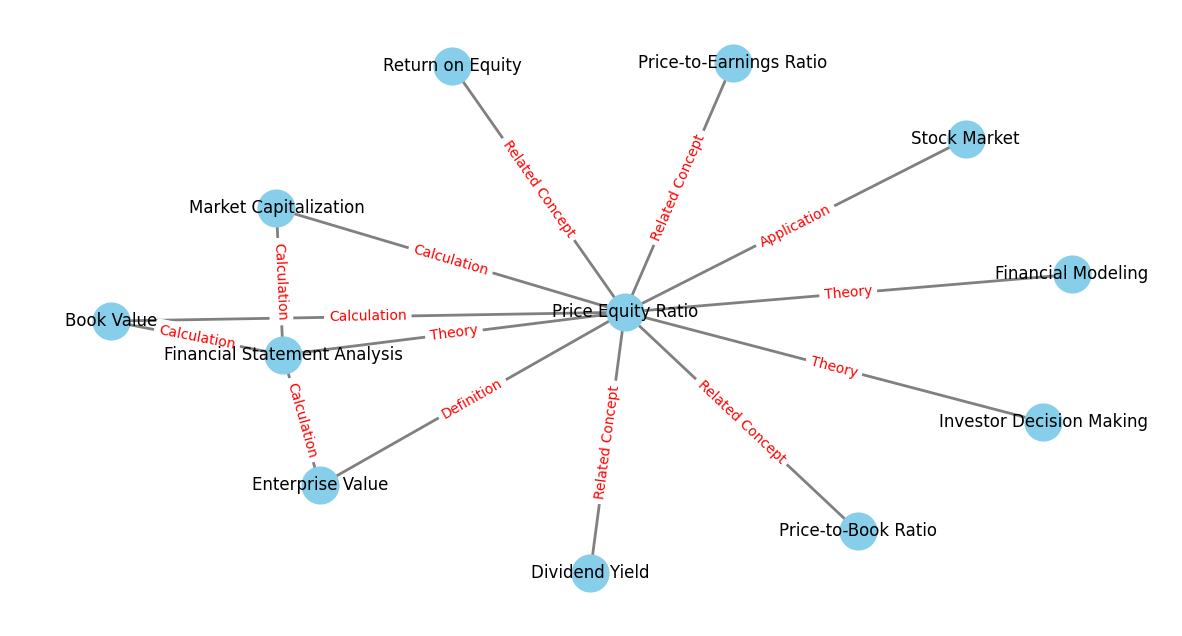

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_knowledge_graph(knowledge_graph, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(knowledge_graph)  # Positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(knowledge_graph, pos, node_size=700, node_color='skyblue')

    # Draw edges
    nx.draw_networkx_edges(knowledge_graph, pos, width=2, edge_color='gray')

    # Draw labels
    nx.draw_networkx_labels(knowledge_graph, pos, font_size=12, font_family="sans-serif")

    # Draw edge labels
    edge_labels = {(u, v): d['label'] for u, v, d in knowledge_graph.edges(data=True)}
    nx.draw_networkx_edge_labels(knowledge_graph, pos, edge_labels=edge_labels, font_color='red')

    # Display the graph without axis
    plt.axis("off")
    plt.show()

# Create the knowledge graph
knowledge_graph_data =v

knowledge_graph = nx.Graph()

# Add nodes and edges from the data
for node in knowledge_graph_data['nodes']:
    knowledge_graph.add_node(node['id'], label=node['label'])

for edge in knowledge_graph_data['edges']:
    knowledge_graph.add_edge(edge['source'], edge['target'], label=edge['label'])

# Visualize the knowledge graph with custom figure size
visualize_knowledge_graph(knowledge_graph, figsize=(15, 8))

